In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# User modifiable values

In [2]:
# path to eeg and marker files respectively
eeg_data_filepath_csv = "data/sub-Mom/ses-S002/eeg/sub-Mom_ses-S002_task-A_run-001_eeg_20241112-163039_OutputFiles/IDUN - EEG_allExp.csv"
marker_data_filepath_csv = "data/sub-Mom/ses-S002/eeg/sub-Mom_ses-S002_task-A_run-001_eeg_20241112-163039_OutputFiles/MarkerStream - Markers_allExp.csv"

# path to XDF file
xdf_filepath = "C:/Users/danij/Documents/Capstone/neuromove/IDUN_P300_test/data/sub-P002/ses-S001/eeg/sub-P002_ses-S001_task-A_run-001_eeg.xdf"

# what target the participant was focusing on
# A = 1, B = 2, ...
target_marker = 'A'

# sampling rate of EEG headset
samplerate = 250.0

# time to view after event
after_event_ms = 600

#synchronize clocks
synch_clocks = False

## Read data from CSV

In [52]:
# read data from files
raw_eeg_data = pd.read_csv(eeg_data_filepath)
raw_marker_data = pd.read_csv(marker_data_filepath)

# convert data to numpy arrays
eeg_data_numpy = raw_eeg_data.to_numpy(na_value=np.nan)
marker_data_numpy = raw_marker_data.to_numpy(na_value=np.nan)

# transpose the data
eeg_data = eeg_data_numpy.T
marker_data_numpy = marker_data_numpy.T

# get timestamps from both data sets
eeg_timestamps = eeg_data[0, :]
eeg_data = eeg_data[1:, :]
marker_timestamps = marker_data_numpy[0, :]
marker_data = marker_data_numpy[1, :]


NameError: name 'eeg_data_filepath' is not defined

## Read data from XDF

In [ ]:
import pyxdf

data, header = pyxdf.load_xdf(xdf_filepath, synchronize_clocks=synch_clocks)

eeg_data = None
eeg_timestamps = None
marker_data = None
marker_timestamps = None

# get the EEG and marker data
for stream in data:
    if stream['info']['type'][0] == 'EEG':
        print("EEG stream found")
        eeg_data = np.array(stream['time_series'])
        eeg_timestamps = np.array(stream['time_stamps'])

    if stream['info']['type'][0] == "Markers":
        print("Marker stream found")
        marker_data = np.array(stream['time_series'])
        marker_timestamps = np.array(stream['time_stamps'])

print("EEG data shape: ", np.shape(eeg_data))
print("EEG timestamps shape: ", np.shape(eeg_timestamps))
print("Marker data shape: ", np.shape(marker_data))
print("Marker timestamps shape: ", np.shape(marker_timestamps))


Stream 1: Calculated effective sampling rate 3.9418 Hz is different from specified rate 250.0000 Hz.


Marker stream found
EEG stream found
EEG data shape:  (133140, 1)
EEG timestamps shape:  (133140,)
Marker data shape:  (2001, 1)
Marker timestamps shape:  (2001,)


In [ ]:

save_eeg = np.transpose([eeg_timestamps, eeg_data[:, 0]])
save_markers = np.transpose([marker_timestamps, marker_data[:, 0]])

# save the data to csv files
np.savetxt("eeg.csv", save_eeg, delimiter=",", header="timestamp, eeg")
np.savetxt("markers.csv", save_markers, delimiter=",", header="timestamp, marker", fmt='%s')

## Filter data

In [10]:
# notch filter to remove powerline noise (60 Hz)
notch_frequency = 60
b, a = signal.iirnotch(notch_frequency, 20, samplerate)
eeg_data_notch_filter = signal.filtfilt(b, a, eeg_data[:, 0])

# bandpass filter to remove noise outside of 1-50 Hz
high_pass_frequency = 0.1
low_pass_frequency = 30
b, a =  signal.iirfilter(int(3), [high_pass_frequency, low_pass_frequency], btype="bandpass", ftype="butter", fs=samplerate, output="ba")
eeg_data_filtered = signal.filtfilt(b, a, eeg_data_notch_filter)


200


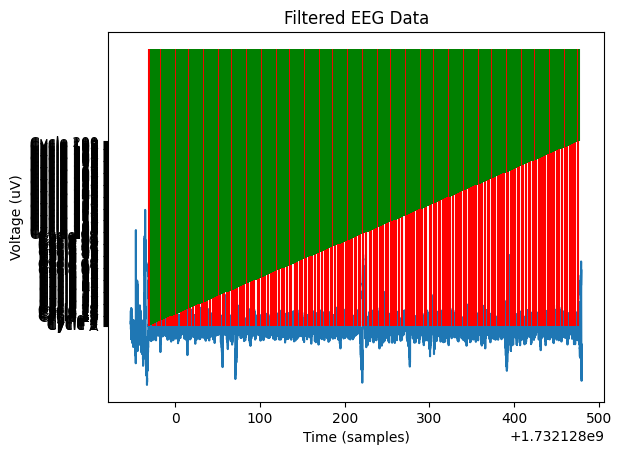

In [ ]:
# plot the filtered data
plt.figure()

plt.plot(eeg_timestamps, eeg_data_filtered)
plt.title("Filtered EEG Data")
plt.xlabel("Time (samples)")
plt.ylabel("Voltage (uV)")

# plot the markers as vertical lines
target_markers = np.array([])
target_markers_timestamps = np.array([])
for i in range(0, len(marker_data)):
    if marker_data[i][0] == target_marker:
        target_markers = np.append(target_markers, marker_data[i])
        target_markers_timestamps = np.append(target_markers_timestamps, marker_timestamps[i])

# plt.vlines(target_markers_timestamps, target_markers, ymax=300, colors='red')

cycle_markers = np.array([])
cycle_markers_timestamps = np.array([])
for i in range(0, len(marker_data)):
    if 'Cycle ' in marker_data[i][0]:
        cycle_markers = np.append(cycle_markers, marker_data[i])
        cycle_markers_timestamps = np.append(cycle_markers_timestamps, marker_timestamps[i])

print(len(cycle_markers))
# plt.vlines(cycle_markers_timestamps, cycle_markers, ymax=300, colors='green')


plt.show()

# Trim out bad sections and re-plot

(array([16069], dtype=int64),)
16069
EEG Data Shape: (19180,)
Timestamp Shape: (19180,)
EEG Data Shape: (16049,)
Timestamp Shape: (16049,)


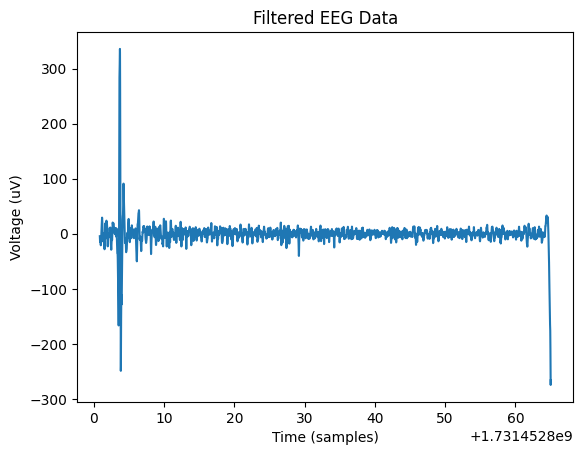

In [7]:
# find the index of the random spike
bad_value = np.max(eeg_data_filtered[0:])
spike_index = np.where(eeg_data_filtered == bad_value)
print(spike_index)

spike_index = spike_index[0][0]
print(spike_index)
# add offset to min_index to get a better view of the spike
spike_index = spike_index - 20

print(f"EEG Data Shape: {eeg_data_filtered.shape}")
print(f"Timestamp Shape: {eeg_timestamps.shape}")

eeg_data_filtered = eeg_data_filtered[:spike_index]
eeg_timestamps = eeg_timestamps[:spike_index]
print(f"EEG Data Shape: {eeg_data_filtered.shape}")
print(f"Timestamp Shape: {eeg_timestamps.shape}")

# np.savetxt("data/sub-Nathan/ses-S001/eeg/sub-Nathan_ses-S001_task-Default_run-001_eeg_20241111-173002_OutputFiles/IDUN - EEG_allExp_filtered.csv", eeg_data_filtered[:], delimiter=",")
# np.savetxt("data/sub-Nathan/ses-S001/eeg/sub-Nathan_ses-S001_task-Default_run-001_eeg_20241111-173002_OutputFiles/MarkerStream - Markers_allExp_filtered.csv", eeg_timestamps, delimiter=",")


# plot the filtered data
plt.figure()
plt.plot(eeg_timestamps, eeg_data_filtered[:])
plt.title("Filtered EEG Data")
plt.xlabel("Time (samples)")
plt.ylabel("Voltage (uV)")
plt.show()

# Get goal timestamps

In [927]:
target_marker = "I"

# helper function
def get_index_of_nearest_timestamp(goal_timestamp, timestamps):
    return np.argmin(np.abs(timestamps - goal_timestamp))

# get timestamps from when the target marker was shown
p300_timestamps = []
for i in range(len(marker_data)):
    if marker_data[i] == target_marker:
        p300_timestamps.append(marker_timestamps[i])

# get coordinating timestamps from the EEG data
p300_eeg_timestamps = []
for t in p300_timestamps:
    p300_eeg_timestamps.append(eeg_timestamps[get_index_of_nearest_timestamp(t, eeg_timestamps)])

In [928]:
print(p300_eeg_timestamps[0])
print(p300_timestamps[0])

print(f"Number of P300 events: {len(p300_timestamps)}")
print(f"eeg timestamps: {p300_eeg_timestamps}")
print(f"marker timestamps: {p300_timestamps}")

1731453931.4277737
1731453931.425794
Number of P300 events: 20
eeg timestamps: [1731453931.4277737, 1731453933.695771, 1731453937.2317665, 1731453938.7437646, 1731453942.2797604, 1731453945.8117561, 1731453947.0757544, 1731453949.095752, 1731453953.131747, 1731453955.9077437, 1731453958.4317405, 1731453959.695739, 1731453961.9677362, 1731453964.7437327, 1731453967.01573, 1731453970.2957258, 1731453973.3237221, 1731453975.5957193, 1731453977.615717, 1731453980.3917136]
marker timestamps: [1731453931.425794, 1731453933.6973922, 1731453937.2309895, 1731453938.7453885, 1731453942.2789857, 1731453945.8125832, 1731453947.0745823, 1731453949.0937808, 1731453953.1321778, 1731453955.9085758, 1731453958.432574, 1731453959.6945732, 1731453961.9661715, 1731453964.7425694, 1731453967.0141678, 1731453970.2953653, 1731453973.3241632, 1731453975.5957615, 1731453977.61496, 1731453980.391358]


# Epoching

In [929]:
fs = 250    # Sampling rate in Hz
samples_per_ms = fs / 1000
samples_after_flash = int(after_event_ms * samples_per_ms)  # 800 ms after flash
print(f"getting {samples_after_flash} samples after flash")

print(eeg_data_filtered.shape)

# Mark the P300 events in the EEG data
eeg_marked = np.vstack((eeg_timestamps, eeg_data_filtered, np.zeros(eeg_data_filtered.shape)))

for t in p300_eeg_timestamps:
    # how far is each timestamp from the target timestamp
    distances = np.abs(eeg_timestamps - t)
    # find the index of the closest timestamp
    index = np.argmin(distances)
    # mark the event
    eeg_marked[2, index] = 1

event_indices = np.where(eeg_marked[2, :] == 1)[0]
print(f"event indices: {event_indices}")
epochs = []

for e in event_indices:
    # end_index = min(e + samples_after_flash, eeg_marked.shape[1])
    end_index = e + samples_after_flash

    # print(f"getting data in range {e} to {end_index}")

    epoch = eeg_marked[:, e:end_index]
    epochs.append(epoch)


print(f"Number of epochs: {len(epochs)}")
epochs = np.array(epochs)
print(f"Shape of epochs: {epochs.shape}")


getting 150 samples after flash
(15180,)
event indices: [ 2057  2624  3508  3886  4770  5653  5969  6474  7483  8177  8808  9124
  9692 10386 10954 11774 12531 13099 13604 14298]
Number of epochs: 20
Shape of epochs: (20, 3, 150)


In [933]:
# cut bad epochs
bad_epochs = [0, 10]
epochs = np.delete(epochs, bad_epochs, axis=0)

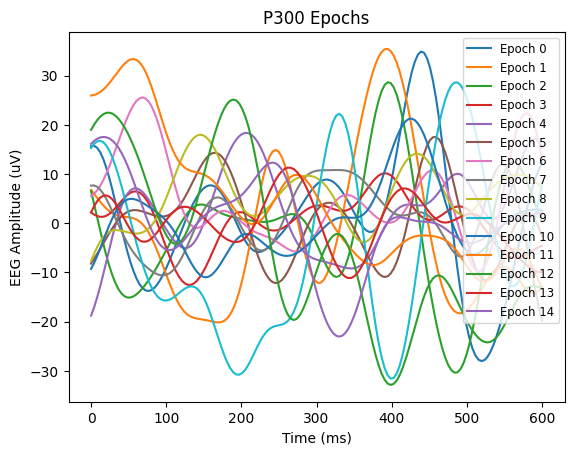

In [934]:
# plot all epochs
no_samples = epochs.shape[2]
time = np.linspace(0, after_event_ms, no_samples)

plt.figure() 
for i in range(epochs.shape[0]):
    plt.plot(time, epochs[i, 1, :], label=f"Epoch {i}")

plt.title("P300 Epochs")
plt.xlabel("Time (ms)")
plt.ylabel("EEG Amplitude (uV)")
plt.legend(loc="upper right", fontsize='small')
plt.show()

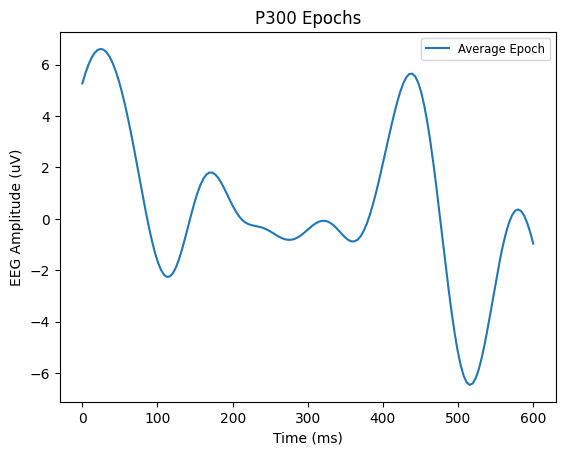

In [935]:
save_image = True
save_location = "data/sub-Mom/ses-S002/target-i/"

# average the epochs
average_epoch = np.mean(epochs[:, 1, :], axis=0)

plt.figure() 
plt.plot(time, average_epoch, label=f"Average Epoch")

plt.title("P300 Epochs")
plt.xlabel("Time (ms)")
plt.ylabel("EEG Amplitude (uV)")
plt.legend(loc="upper right", fontsize='small')

if save_image:

    plt.savefig(f"{save_location}average-{target_marker}.png")

plt.show()